In [43]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from importlib import import_module
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(1000)
ONE_HOT_LABEL = False

In [44]:
def count_data(data):
    if ONE_HOT_LABEL:
        data = data.dot(np.arange(0,5)).astype('uint8')
    unique, counts = np.unique(data, return_counts=True)
    print(dict(zip(unique, counts)))

In [45]:
# # (2) Get Data
# import tflearn.datasets.oxflower17 as oxflower17
# x, y = oxflower17.load_data(one_hot=True)

DATADIR = '/Users/yanxiang.zyx/KIPRO/associative_deep_clustering/semisup/data/npy/'

dataset_tools = import_module('tools.material')

train_images, test_images, train_labels,  test_labels = dataset_tools.get_data(one_hot=ONE_HOT_LABEL, test_size=0.2, random_state=1)

class_names = ['Cardboard', 'Pamphlet', 'Empty', 'Plastic Foil', 'Shredded Paper']

NUM_LABELS = dataset_tools.NUM_LABELS
IMAGE_SHAPE = dataset_tools.IMAGE_SHAPE

print(train_images.shape)
count_data(train_labels)
count_data(test_labels)


(400, 227, 227, 3)
{0: 84, 1: 81, 2: 84, 3: 74, 4: 77}
{0: 16, 1: 19, 2: 16, 3: 26, 4: 23}


In [46]:
# (3) Create a sequential model
model = Sequential()

# model.add(Dropout(0.5, input_shape=IMAGE_SHAPE))
# model.add(BatchNormalization(input_shape=IMAGE_SHAPE, \
#         axis=-1, momentum=0.9, epsilon=0.001, center=True, scale=True, beta_initializer='zeros',\
#         gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None,\
#         gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=IMAGE_SHAPE, \
     kernel_size=(11,11), strides=(4,4), padding='valid', \
     trainable=False, kernel_initializer='glorot_uniform', \
     activation = 'relu'))

# Pooling 
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), \
#         trainable=False, \
        padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', \
         trainable=False, kernel_initializer='glorot_uniform', \
         activation = 'relu'))

# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), \
#         trainable=False, \
        padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', \
         trainable=False, kernel_initializer='glorot_uniform', \
         activation = 'relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', \
        kernel_initializer='glorot_uniform', \
         activation = 'relu'))
# model.add(BatchNormalization(momentum=0.9))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', \
      kernel_initializer='glorot_uniform', \
      activation = 'relu'))
# model.add(BatchNormalization(momentum=0.9))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 2nd Dense Layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 13, 13, 256)      

In [47]:
def get_lr_metric(a):
    def lr(y_true, y_pred):
        return a.lr
    return lr

In [48]:
# (4) Compile 
loss_func = 'categorical_crossentropy' if ONE_HOT_LABEL else 'sparse_categorical_crossentropy'
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0001, amsgrad=False)
# model.compile(loss=loss_func, optimizer=adam, metrics=['accuracy'])
lr_metric = get_lr_metric(adam)
model.compile(loss=loss_func, optimizer=adam, metrics=['accuracy', lr_metric])
each_epoch = 10
total_epochs = 0

In [58]:
generated_data = ImageDataGenerator(featurewise_center=False, samplewise_center=False, zoom_range=0.25,
                                            featurewise_std_normalization=False, samplewise_std_normalization=False,
                                            zca_whitening=False, rotation_range=90, horizontal_flip=False)

generated_data.fit(train_images, augment=True)

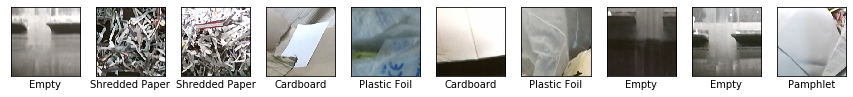

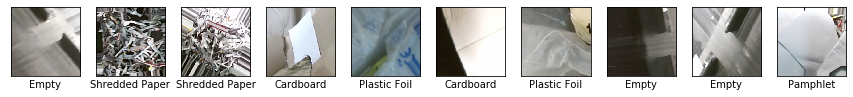

In [68]:
# plot original images
figsize=(15,15)
plt.figure(figsize=figsize)
display_num = 10
for i in range(display_num):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    class_label = np.argmax(train_labels[i]) if ONE_HOT_LABEL else train_labels[i]
    plt.xlabel(class_names[class_label])
plt.show()

# plot augmented images
plt.figure(figsize=figsize)
for X_batch, y_batch in generated_data.flow(train_images, train_labels, batch_size=16, shuffle=False):
    for i in range(display_num):
        plt.subplot(10,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = X_batch[i].astype('uint8')
        plt.imshow(image, cmap=plt.cm.binary)
        class_label = np.argmax(y_batch[i]) if ONE_HOT_LABEL else y_batch[i]
        plt.xlabel(class_names[class_label])
    plt.show()
    break


In [69]:
# (5) Train
print(total_epochs)
total_epochs += each_epoch

augmented_data = generated_data.flow(train_images, train_labels, batch_size=16)
model.fit_generator(augmented_data, validation_data=(test_images, test_labels), 
                    steps_per_epoch=10, epochs=each_epoch, shuffle=True)

# model.fit(train_images, train_labels, epochs=each_epoch, verbose=1, 
#                         validation_split=0.2, shuffle=True, batch_size=16)



50
Epoch 1/100
100/100 [==============================] - 15s 147ms/step - loss: 0.7386 - accuracy: 0.6850 - lr: 1.0000e-04 - val_loss: 0.7008 - val_accuracy: 0.7400 - val_lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - 15s 146ms/step - loss: 0.7906 - accuracy: 0.6644 - lr: 1.0000e-04 - val_loss: 0.9794 - val_accuracy: 0.6600 - val_lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - 15s 147ms/step - loss: 0.7197 - accuracy: 0.6956 - lr: 1.0000e-04 - val_loss: 0.8841 - val_accuracy: 0.7100 - val_lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - 15s 148ms/step - loss: 0.7473 - accuracy: 0.6825 - lr: 1.0000e-04 - val_loss: 0.6936 - val_accuracy: 0.7700 - val_lr: 1.0000e-04
Epoch 5/100
100/100 [==============================] - 15s 147ms/step - loss: 0.7113 - accuracy: 0.7056 - lr: 1.0000e-04 - val_loss: 0.7154 - val_accuracy: 0.7700 - val_lr: 1.0000e-04
Epoch 6/100
100/100 [==============================] - 15s 146ms/step - loss:

KeyboardInterrupt: 

In [41]:
test_loss, test_acc, test_lr = model.evaluate(test_images,  test_labels, verbose=1)

print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)
print('\nTest lr:', test_lr)

50/50 [==============================] - 0s 392us/step

Test loss: 0.7557825863361358

Test accuracy: 0.7599999904632568

Test lr: 9.999999747378752e-05


In [42]:
pred_images, pred_labels = train_images, train_labels

predictions = model.predict(pred_images)

pred_len = len(predictions)
count = 0
for i in range(pred_len):
    _label = np.argmax(pred_labels[i]) if ONE_HOT_LABEL else pred_labels[i]
    if _label == np.argmax(predictions[i]):
        count += 1
print(count)
print(count/pred_len)

416
0.9244444444444444


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  if ONE_HOT_LABEL:
    true_label = np.argmax(true_label)
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  if ONE_HOT_LABEL:
    true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(NUM_LABELS))
  plt.yticks([])
  thisplot = plt.bar(range(NUM_LABELS), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], pred_labels, pred_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], pred_labels)
plt.tight_layout()
plt.show()